In [1]:
import sys
import importlib
# Make imports work
sys.path.insert(0, '../')

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from colour import Color
from mhealth_anomaly_detection import anomaly_detection
from mhealth_anomaly_detection import format_axis as fa
from mhealth_anomaly_detection import load_refs as lr
from mhealth_anomaly_detection import plots

/Users/sakre/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [216]:
YEAR = 3
EXPERIMENT = 'exp05'
exp06_ad = pd.read_csv(
    Path('../cache', f'GLOBEM-{YEAR}_{EXPERIMENT}_intermediate.csv')    
)
exp06 = pd.read_csv(
    Path('../cache', f'GLOBEM-{YEAR}_{EXPERIMENT}.csv')    
)
exp06_ad

/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_89880/98105369.py:3: DtypeWarning: Columns (66,67,68,69,70,71,72,73,74,75,76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  exp06_ad = pd.read_csv(


,subject_id,study_day,window_size,platform,date,f_slp:fitbit_sleep_intraday_rapids_mediandurationasleepunifiedmain:allday,f_slp:fitbit_sleep_intraday_rapids_stddurationasleepunifiedmain:allday,f_slp:fitbit_sleep_intraday_rapids_countepisodeasleepunifiedmain:allday,f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:allday,f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain:allday,...,NMF_003_anomaly,SVM_poly_anomaly,PCA_005_anomaly,NMF_005_anomaly,SVM_rbf_anomaly,SVM_sigmoid_anomaly,PCA_010_anomaly,NMF_010_anomaly,PCA_020_anomaly,NMF_020_anomaly
0,INS-W_600,0,7,ios,2020-03-16,NaN,NaN,NaN,NaN,NaN,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,INS-W_600,1,7,ios,2020-03-17,NaN,NaN,NaN,NaN,NaN,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,INS-W_600,2,7,ios,2020-03-18,NaN,NaN,NaN,NaN,NaN,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,INS-W_600,3,7,ios,2020-03-19,NaN,NaN,NaN,NaN,NaN,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,INS-W_600,4,7,ios,2020-03-20,NaN,NaN,NaN,NaN,NaN,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132735,INS-W_761,98,28,ios,2020-06-22,19.999667,52.146919,9.0,430.992817,154.497425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
132736,INS-W_761,99,28,ios,2020-06-23,19.999667,52.146919,9.0,430.992817,154.497425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
132737,INS-W_761,100,28,ios,2020-06-24,19.999667,52.146919,9.0,430.992817,154.497425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
132738,INS-W_761,101,28,ios,2020-06-25,19.999667,52.146919,9.0,430.992817,154.497425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [228]:
exp06_ad.subject_id.nunique()

128

In [217]:
FEATURES = [
    'f_loc:phone_locations_doryab_locationentropy:allday',
    'f_loc:phone_locations_barnett_circdnrtn:allday',
    'f_steps:fitbit_steps_intraday_rapids_sumsteps:allday',
    'f_steps:fitbit_steps_intraday_rapids_sumdurationactivebout:allday',
    'f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:allday',
    'f_slp:fitbit_sleep_intraday_rapids_countepisodeasleepunifiedmain:allday',
    'f_slp:fitbit_sleep_summary_rapids_firstbedtimemain:allday',
    'f_slp:fitbit_sleep_summary_rapids_avgefficiencymain:allday',
    'f_call:phone_calls_rapids_missed_count:allday',
    'f_call:phone_calls_rapids_incoming_count:allday',
    'f_call:phone_calls_rapids_outgoing_count:allday',
    'f_call:phone_calls_rapids_outgoing_sumduration:allday',
    'sleep_missing',
    'steps_missing',
    'location_missing',
    'call_missing',
]
FEATURES = [c for c in FEATURES if c in exp06_ad.columns]

In [218]:
from mhealth_anomaly_detection import datasets
importlib.reload(datasets)
GLOBEM = datasets.GLOBEM(year=YEAR, load_data=False)
prepost = GLOBEM.get_pre_post_surveys()

In [219]:
surveys = [c.removesuffix('_CHANGE') for c in prepost.columns if c not in ['subject_id', 'pre_date', 'post_date'] and c.endswith('_CHANGE')]
print(surveys)
prepost

['UCLA_10items', 'SocialFit', '2waySSS_receiving_emotional', '2waySSS_giving_emotional', '2waySSS_giving_instrumental', '2waySSS_receiving_instrumental', 'ERQ_reappraisal', 'ERQ_suppression', 'BRS', 'CHIPS', 'PSS_10items', 'PSS_14items', 'STAI', 'MAAS_15items', 'CESD_9items', 'CESD_10items', 'BDI2', 'BriefCope_adaptive', 'BriefCope_maladaptive', 'GQ', 'FSPWB', 'EDS', 'CEDH', 'BYAACQ']


,subject_id,pre_date,UCLA_10items_PRE,SocialFit_PRE,2waySSS_receiving_emotional_PRE,2waySSS_giving_emotional_PRE,2waySSS_giving_instrumental_PRE,2waySSS_receiving_instrumental_PRE,ERQ_reappraisal_PRE,ERQ_suppression_PRE,...,CESD_9items_CHANGE,CESD_10items_CHANGE,BDI2_CHANGE,BriefCope_adaptive_CHANGE,BriefCope_maladaptive_CHANGE,GQ_CHANGE,FSPWB_CHANGE,EDS_CHANGE,CEDH_CHANGE,BYAACQ_CHANGE
0,INS-W_600,2020-03-12,28.0,78.0,31.0,23.0,19.0,15.0,4.166667,2.00,...,-7.0,-9.0,-6.0,-0.5000,-0.250000,-7.0,0.0,-9.0,-17.0,8.0
1,INS-W_601,2020-03-15,22.0,85.0,28.0,20.0,19.0,19.0,4.666667,4.75,...,-2.0,-2.0,0.0,1.0000,-0.250000,-2.0,1.0,4.0,9.0,5.0
2,INS-W_602,2020-03-11,22.0,76.0,32.0,18.0,14.0,19.0,4.666667,3.25,...,1.0,0.0,3.0,0.5000,0.416667,-1.0,3.0,-8.0,0.0,NaN
3,INS-W_603,2020-03-15,15.0,87.0,26.0,19.0,20.0,15.0,6.166667,5.00,...,2.0,3.0,-1.0,-1.0000,-0.416667,-3.0,-4.0,-10.0,-1.0,-4.0
4,INS-W_604,2020-03-16,31.0,73.0,15.0,8.0,5.0,5.0,4.666667,5.50,...,1.0,0.0,2.0,-0.4375,-0.083333,3.0,-10.0,-8.0,-2.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,INS-W_756,2020-03-14,18.0,89.0,34.0,20.0,24.0,18.0,5.833333,6.00,...,2.0,1.0,3.0,-0.5000,0.083333,4.0,2.0,0.0,-4.0,NaN
138,INS-W_757,2020-03-30,31.0,79.0,15.0,9.0,9.0,11.0,4.666667,5.50,...,3.0,5.0,10.0,0.0000,0.333333,-6.0,-13.0,0.0,0.0,-3.0
139,INS-W_758,2020-03-28,16.0,78.0,30.0,21.0,13.0,15.0,4.166667,4.50,...,-1.0,-1.0,-1.0,0.3750,0.583333,7.0,2.0,0.0,-7.0,-2.0
140,INS-W_759,2020-04-01,23.0,69.0,26.0,20.0,15.0,12.0,4.333333,3.25,...,-10.0,-11.0,-15.0,0.0625,-0.333333,3.0,7.0,7.0,-1.0,NaN


In [220]:
filt_06 = exp06_ad.merge(prepost)
filt_06 = filt_06[(filt_06.date >= filt_06.pre_date) & (filt_06.date <= filt_06.post_date)]
filt_06.shape, exp06_ad.shape

((97640, 157), (132740, 78))

<Axes: ylabel='subject_id'>

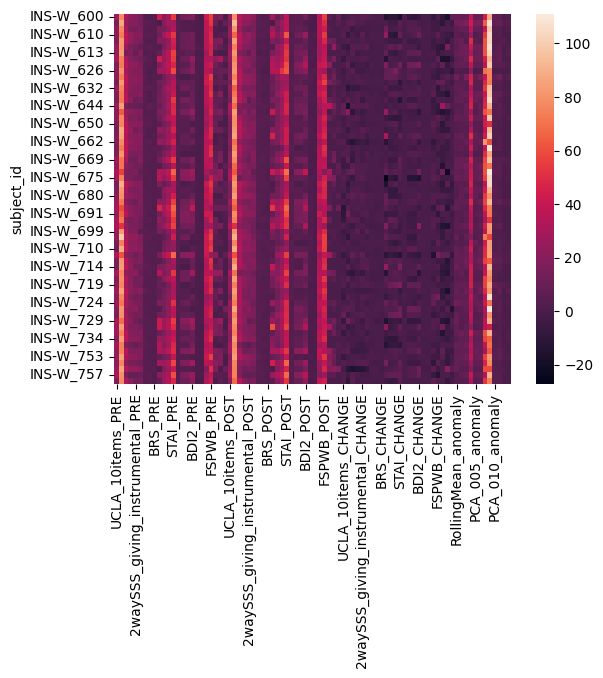

In [221]:
anomaly_detector_cols = [
    d for d in exp06_ad.columns if d.endswith("_anomaly")
]
survey_cols = [
    *[c + '_PRE' for c in surveys],
    *[c + '_POST' for c in surveys],
    *[c + '_CHANGE' for c in surveys]
]
study_level = filt_06.groupby([
    'subject_id',
    *survey_cols,
])[anomaly_detector_cols].sum().reset_index()
sns.heatmap(study_level.set_index('subject_id'))

In [222]:
corr_dfs = []
study_level['year'] = YEAR
study_level['study'] = 'GLOBEM'
for s in surveys:
    for target in ['CHANGE']:
        outcome_col = f'{s}_{target}'
        corr_df = anomaly_detection.correlateDetectedToOutcome(
            detected_anomalies=study_level,
            anomaly_detector_cols=anomaly_detector_cols,
            outcome_col=outcome_col,
            groupby_cols=['year', 'study']
        )
        corr_df['outcome'] = outcome_col
        corr_df['survey'] = s
        corr_df['target'] = target
        corr_dfs.append(corr_df)
study_corrs = pd.concat(corr_dfs)
study_corrs

,detector,rho,p,n,year,study,outcome,survey,target
0,RollingMean_anomaly,-0.161418,0.210067,62,3,GLOBEM,UCLA_10items_CHANGE,UCLA_10items,CHANGE
1,PCA_003_anomaly,-0.015885,0.902469,62,3,GLOBEM,UCLA_10items_CHANGE,UCLA_10items,CHANGE
2,NMF_003_anomaly,0.044100,0.733601,62,3,GLOBEM,UCLA_10items_CHANGE,UCLA_10items,CHANGE
3,SVM_poly_anomaly,-0.070368,0.586802,62,3,GLOBEM,UCLA_10items_CHANGE,UCLA_10items,CHANGE
4,PCA_005_anomaly,-0.131176,0.309506,62,3,GLOBEM,UCLA_10items_CHANGE,UCLA_10items,CHANGE
...,...,...,...,...,...,...,...,...,...
7,SVM_sigmoid_anomaly,-0.079175,0.540737,62,3,GLOBEM,BYAACQ_CHANGE,BYAACQ,CHANGE
8,PCA_010_anomaly,-0.111367,0.388826,62,3,GLOBEM,BYAACQ_CHANGE,BYAACQ,CHANGE
9,NMF_010_anomaly,-0.093962,0.467587,62,3,GLOBEM,BYAACQ_CHANGE,BYAACQ,CHANGE
10,PCA_020_anomaly,0.054801,0.672269,62,3,GLOBEM,BYAACQ_CHANGE,BYAACQ,CHANGE


,subject_id,outcome,score,survey,target,max_score,score_norm
0,INS-W_600,UCLA_10items_PRE,28.0,UCLA_10items,PRE,35.0,0.800000
1,INS-W_601,UCLA_10items_PRE,22.0,UCLA_10items,PRE,35.0,0.628571
2,INS-W_602,UCLA_10items_PRE,22.0,UCLA_10items,PRE,35.0,0.628571
3,INS-W_603,UCLA_10items_PRE,15.0,UCLA_10items,PRE,35.0,0.428571
4,INS-W_604,UCLA_10items_PRE,31.0,UCLA_10items,PRE,35.0,0.885714
...,...,...,...,...,...,...,...
10219,INS-W_756,BYAACQ_CHANGE,NaN,BYAACQ,CHANGE,17.0,NaN
10220,INS-W_757,BYAACQ_CHANGE,-3.0,BYAACQ,CHANGE,17.0,-0.176471
10221,INS-W_758,BYAACQ_CHANGE,-2.0,BYAACQ,CHANGE,17.0,-0.117647
10222,INS-W_759,BYAACQ_CHANGE,NaN,BYAACQ,CHANGE,17.0,NaN


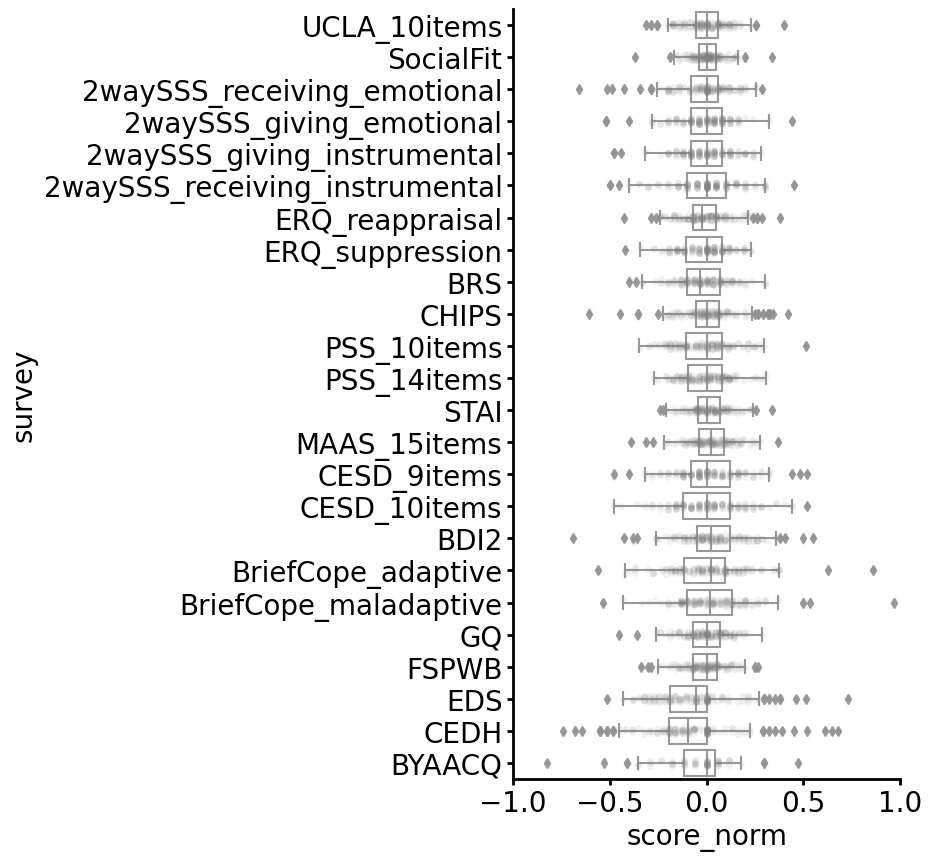

In [223]:
prepost_melt = prepost[['subject_id', *survey_cols]].melt(id_vars='subject_id', var_name='outcome', value_name='score')
prepost_melt['survey'] = prepost_melt['outcome'].str.split('_').str[:-1].str.join('_')
prepost_melt['target'] = prepost_melt['outcome'].str.split('_').str[-1]
survey_max = prepost_melt.groupby('survey').score.max().reset_index().rename(columns={'score': 'max_score'})
prepost_melt = prepost_melt.merge(survey_max)
prepost_melt['score_norm'] = prepost_melt['score']/prepost_melt['max_score']

fig, ax = plt.subplots(figsize=(5,10))
sns.stripplot(
    x='score_norm',
    y='survey',
    data=prepost_melt[prepost_melt.target == 'CHANGE'],
    alpha=.1,
    color='gray',
    ax=ax
)
sns.boxplot(
    x='score_norm',
    y='survey',
    data=prepost_melt[prepost_melt.target == 'CHANGE'],
    color='white',
    ax=ax
)
ax.set_xlim([-1, 1])
fa.despine_thicken_axes(ax, )
prepost_melt

In [224]:
study_corr_piv.shape, study_corr_piv.shape[0] * study_corr_piv.shape[1]


((10, 24), 240)

<Axes: xlabel='survey', ylabel='model'>

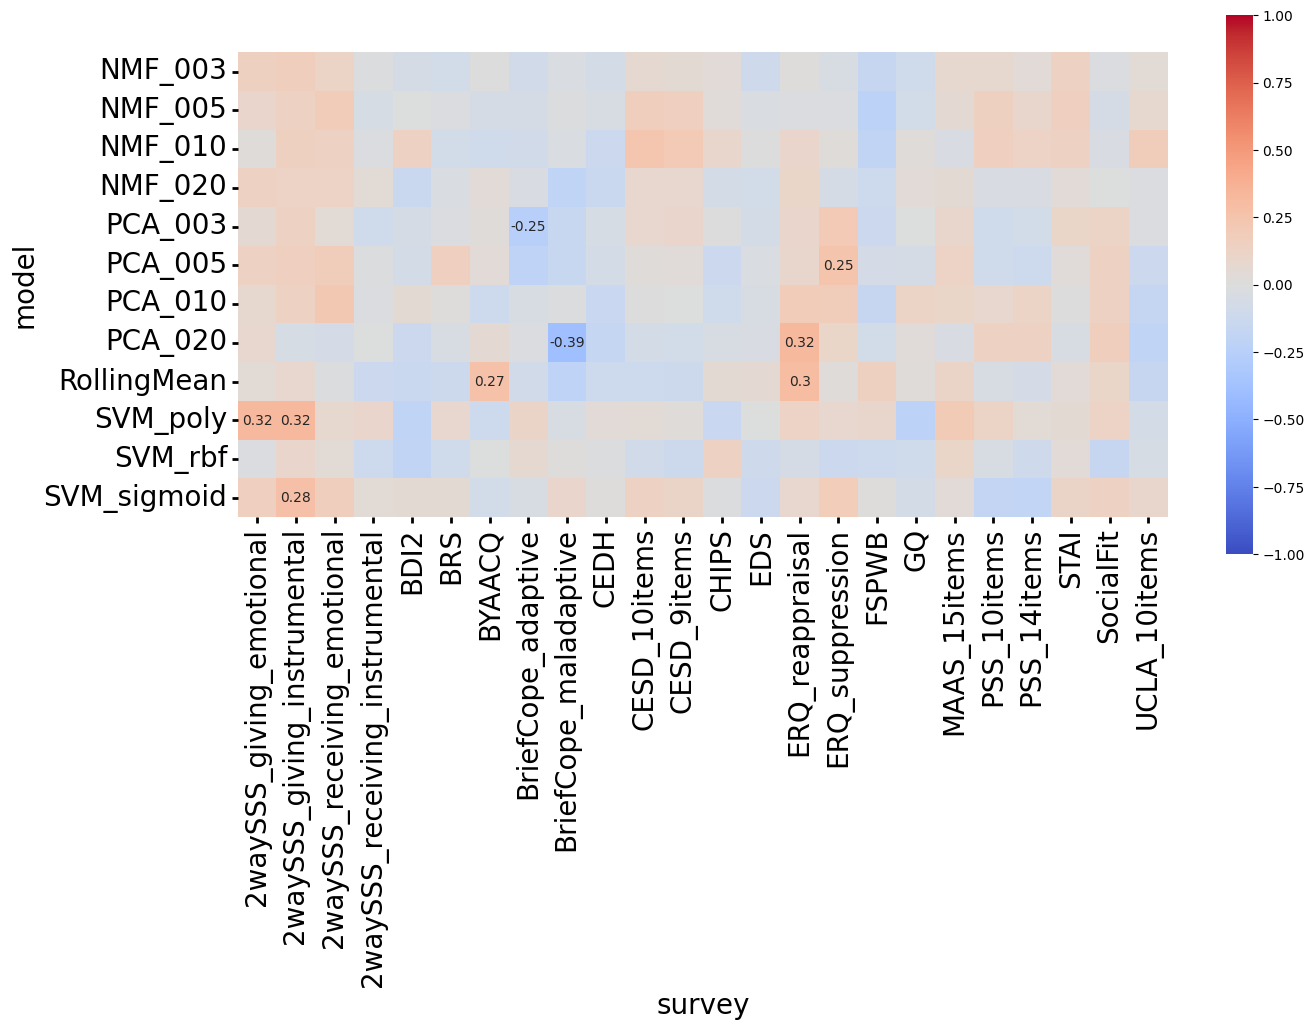

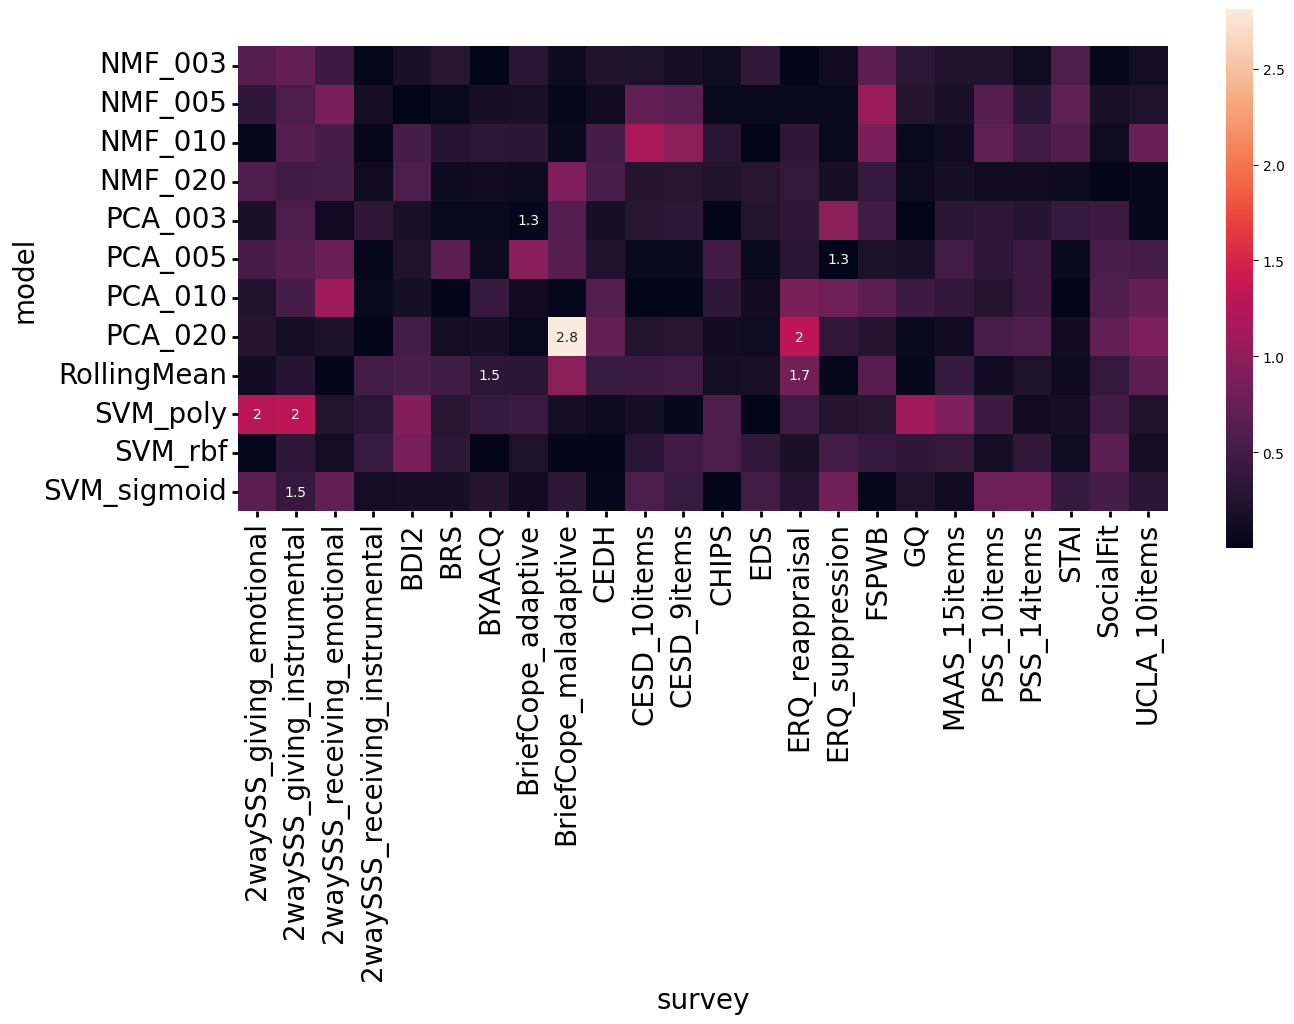

In [225]:
study_corrs['model'] = study_corrs.detector.str.removesuffix('_anomaly')
study_corr_piv = study_corrs.pivot_table(
    index=['model'],
    columns='survey',
    values='rho',
)
study_corr_p_piv = study_corrs.pivot_table(
    index=['model'],
    columns='survey',
    values='p',
) # * study_corr_piv.shape[0] * study_corr_piv.shape[1]
sig = study_corr_p_piv >= 0.05
fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(
    study_corr_piv,
    vmin=-1,
    vmax=1,
    cmap='coolwarm',
    square=True,
    ax=ax
)
sns.heatmap(
    study_corr_piv,
    vmin=-1,
    vmax=1,
    cmap='coolwarm',
    square=True,
    mask=sig,
    annot=study_corr_piv.round(2),
    annot_kws={'fontsize': 10},
    cbar=False,
    ax=ax
)
fa.despine_thicken_axes(ax, heatmap=True, x_rotation=90)

fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(
    np.log10(1/study_corr_p_piv),
    square=True,
    ax=ax
)
sns.heatmap(
    np.log10(1/study_corr_p_piv),
    square=True,
    mask=sig,
    annot=np.log10(1/study_corr_p_piv).round(2),
    annot_kws={'fontsize': 10},
    cbar=False,
    ax=ax
)
fa.despine_thicken_axes(ax, heatmap=True, x_rotation=90)

<Axes: xlabel='BriefCope_maladaptive_CHANGE', ylabel='PCA_020_anomaly'>

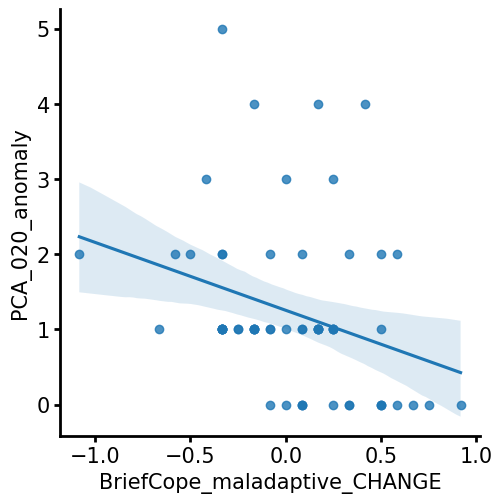

In [227]:
#ax = sns.scatterplot(
#    x='2waySSS_giving_emotional_CHANGE',
#    y='NMF_010_anomaly',
#    data=study_level,
#)
fg = sns.lmplot(
    x='BriefCope_maladaptive_CHANGE',
    y='PCA_020_anomaly',
    data=study_level,
)
ax = fg.axes.flatten()[0]
fa.despine_thicken_axes(ax, fontsize=15)

In [10]:
p_list = []
for period in [1, 2, 3]:
    p_list.append(GLOBEM.get_phq_periods(
        exp06_ad,
        features=FEATURES,
        period=period
    ))
exp06_comb = pd.concat(p_list)
exp06_comb

1848it [00:12, 143.19it/s]
1848it [00:11, 158.86it/s]
1848it [00:09, 185.00it/s]


,subject_id,start,stop,days,complete_days,phq_start,phq_stop,phq_change,RollingMean_anomaly,PCA_3_anomaly,...,SVM_poly_anomaly,PCA_5_anomaly,NMF_5_anomaly,SVM_rbf_anomaly,SVM_sigmoid_anomaly,PCA_10_anomaly,NMF_10_anomaly,PCA_20_anomaly,NMF_20_anomaly,period
0,INS-W_300,10,17,7,70,2.0,3.0,1.0,0,0,...,2,0,0,1,4,0,0,0,0,1
1,INS-W_300,17,21,7,40,3.0,3.0,0.0,0,0,...,0,0,0,3,1,0,0,0,0,1
2,INS-W_300,21,31,7,100,3.0,5.0,2.0,1,1,...,12,1,1,5,8,0,0,0,0,1
3,INS-W_300,31,38,7,70,5.0,5.0,0.0,0,2,...,8,2,0,3,7,1,0,0,0,1
4,INS-W_300,38,45,7,70,5.0,2.0,-3.0,1,1,...,9,1,0,19,2,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,INS-W_572,21,45,24,240,7.0,5.0,-2.0,0,1,...,31,1,0,32,25,1,0,0,0,3
1268,INS-W_572,31,49,24,180,6.0,6.0,0.0,0,1,...,25,1,0,21,21,1,0,0,0,3
1269,INS-W_572,38,59,24,210,4.0,2.0,-2.0,0,1,...,27,2,0,23,30,1,0,0,0,3
1270,INS-W_572,45,66,24,210,5.0,7.0,2.0,2,6,...,30,5,3,21,34,4,1,1,0,3


In [11]:
anomaly_detector_cols = [
    d for d in exp06_ad.columns if d.endswith("_anomaly")
]
palette = lr.get_colors('../lib/colors.json')

In [12]:
exp06_ad.study_day.max()

96

KeyError: 'PCA_3'

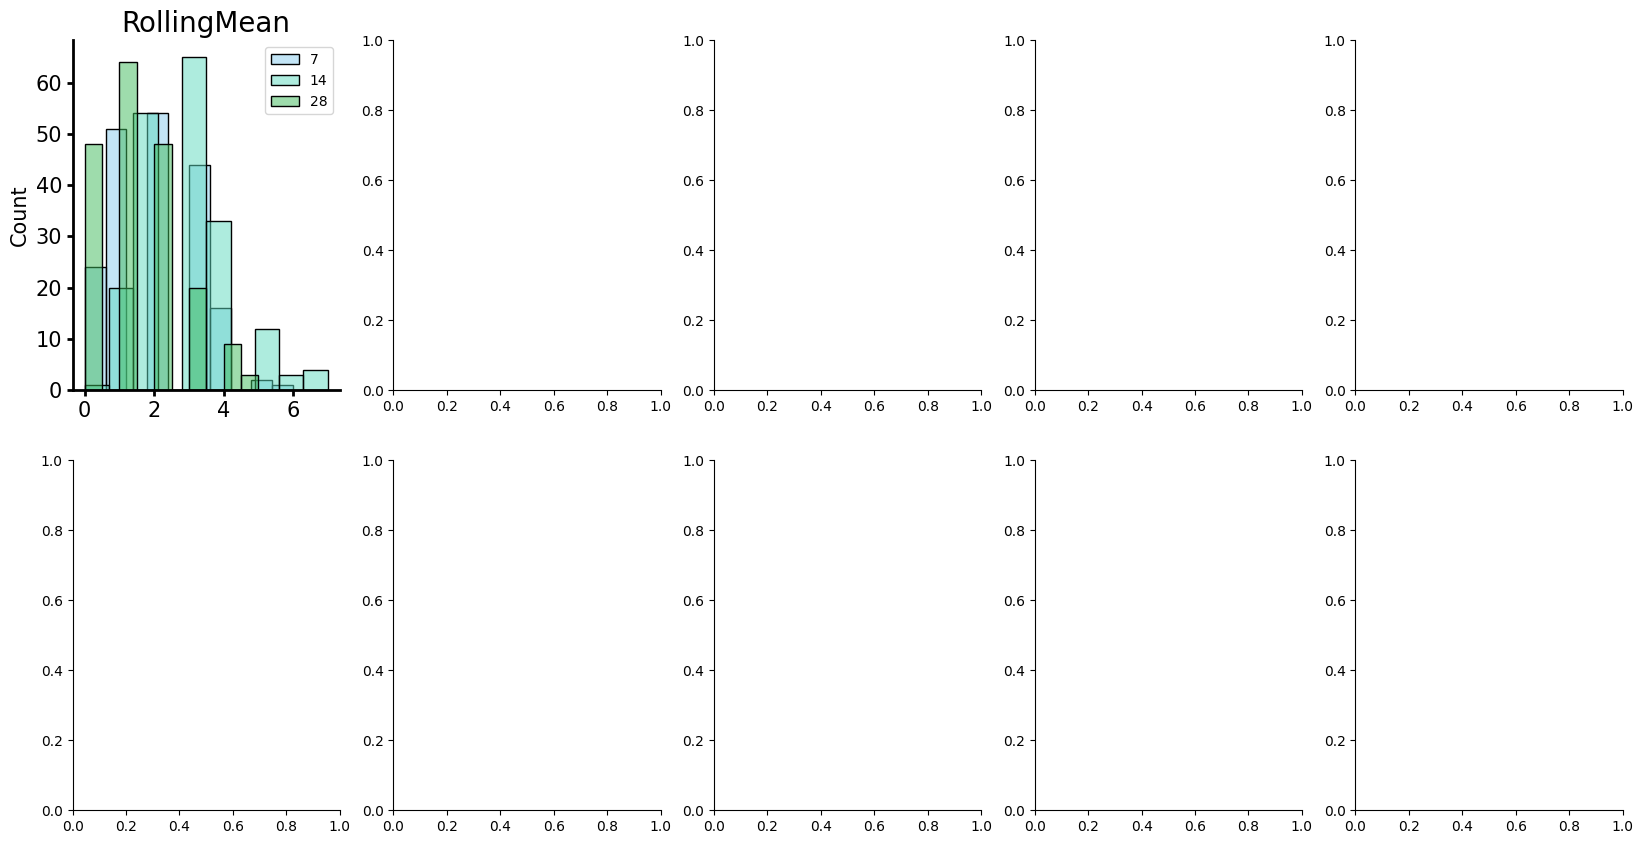

In [13]:
anoms = exp06_ad.groupby(['subject_id', 'window_size'])[anomaly_detector_cols].sum().reset_index()
fig, axes = plt.subplots(figsize=(20,10), nrows=2, ncols=5)
gray = Color("black")

for i, ad in enumerate(anomaly_detector_cols):
    ax = axes.flatten()[i]
    dname = ad.split('_anomaly')[0]
    base_c = Color(palette['model'][dname])
    p = list(base_c.range_to(gray, 7))
    for i, (ws, w_df) in enumerate(anoms.groupby('window_size')):
        sns.histplot(
            w_df[ad],
            color=p[i].hex_l,
            ax=ax,
            bins=10,
            alpha=.5,
            label=ws
        )
    ax.set_title(dname.replace('_', ' '), fontsize=20)
    ax.legend()
    ax.set_xlabel('')
    fa.despine_thicken_axes(ax, fontsize=15)


In [ ]:
importlib.reload(anomaly_detection)
target = 'phq_stop'
phq_anomalies_qc = exp06_comb[
    (exp06_comb.days >= exp06_comb.period*6) & 
    (exp06_comb.days <= exp06_comb.period*8)
]
info_cols = [
    'subject_id',
    'period',
    #'window_size',
]
corr = anomaly_detection.correlateDetectedToOutcome(
    phq_anomalies_qc,
    anomaly_detector_cols,
    outcome_col=target,
    groupby_cols=info_cols,
)
corr.sort_values(by='rho')

,detector,rho,p,n,subject_id,period
615,NMF_005_anomaly,-1.000000,0.000000e+00,5,INS-W_330,2
611,PCA_003_anomaly,-1.000000,0.000000e+00,5,INS-W_330,2
612,NMF_003_anomaly,-1.000000,0.000000e+00,5,INS-W_330,2
2483,SVM_poly_anomaly,-1.000000,0.000000e+00,3,INS-W_411,3
2480,RollingMean_anomaly,-1.000000,0.000000e+00,3,INS-W_411,3
...,...,...,...,...,...,...
1939,NMF_010_anomaly,0.989743,2.676787e-06,8,INS-W_386,2
1929,NMF_010_anomaly,0.992157,1.396235e-07,9,INS-W_386,1
3627,SVM_sigmoid_anomaly,1.000000,0.000000e+00,5,INS-W_471,3
1948,PCA_010_anomaly,1.000000,0.000000e+00,7,INS-W_386,3


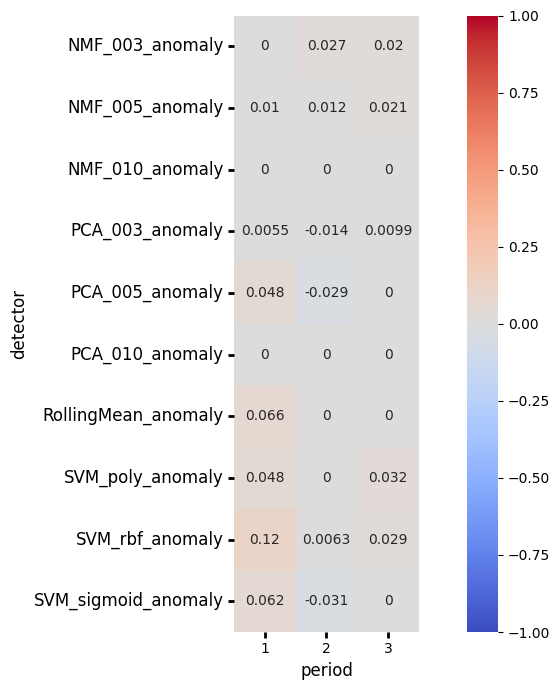

In [ ]:

info_cols = [
    'period',
    'window_size',
]
for target in ['phq_stop']:
    corr['r2'] = corr['rho'] ** 2
    for metric in ['rho']:
        corr_table = corr.pivot_table(
            index=['detector'],
            columns=['period'],
            values='rho',
            aggfunc='median'
        )
        hm_size = (10, 7)
        fig, ax = plt.subplots(figsize=hm_size)
        sns.heatmap(
            corr_table,
            center=0,
            vmin=-1,
            vmax=1,
            square=True,
            annot=True,
            cmap='coolwarm',
            ax=ax
        )
        fa.despine_thicken_axes(ax, heatmap=True, fontsize=12, x_tick_fontsize=10)
        plt.tight_layout()

<AxesSubplot: xlabel='rho', ylabel='subject_id'>

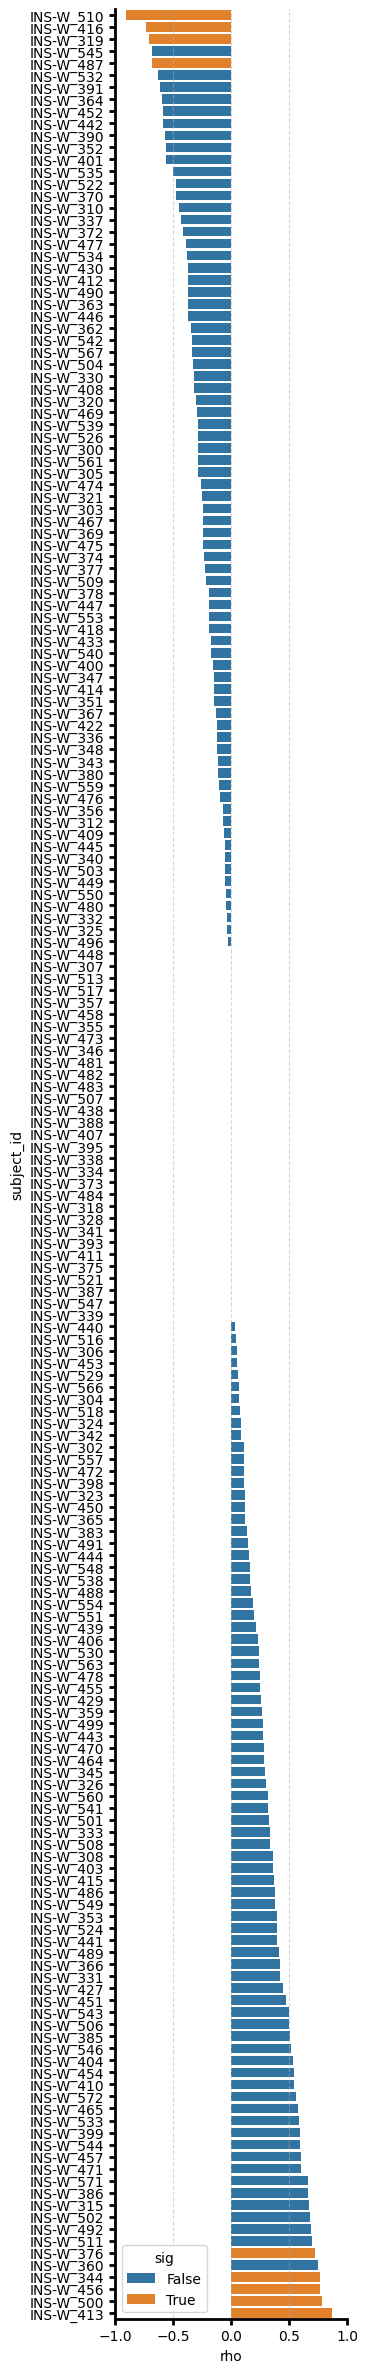

In [ ]:
fig, ax = plt.subplots(figsize=(3,30))
subset = corr[
    (corr.period == 1) &
    (corr.detector == 'PCA_010_anomaly')
].sort_values(by='rho')
subset['log10p'] = np.log10(subset['p'])
subset['sig'] = subset['p'] < 0.05
sns.barplot(
    x='rho',
    y='subject_id',
    hue='sig',
    data=subset,
    dodge=False,
    ax=ax,
)
ax.set_xlim(-1, 1)
ax.grid(axis='x', alpha=.5, ls='dashed')
fa.despine_thicken_axes(ax, fontsize=10)


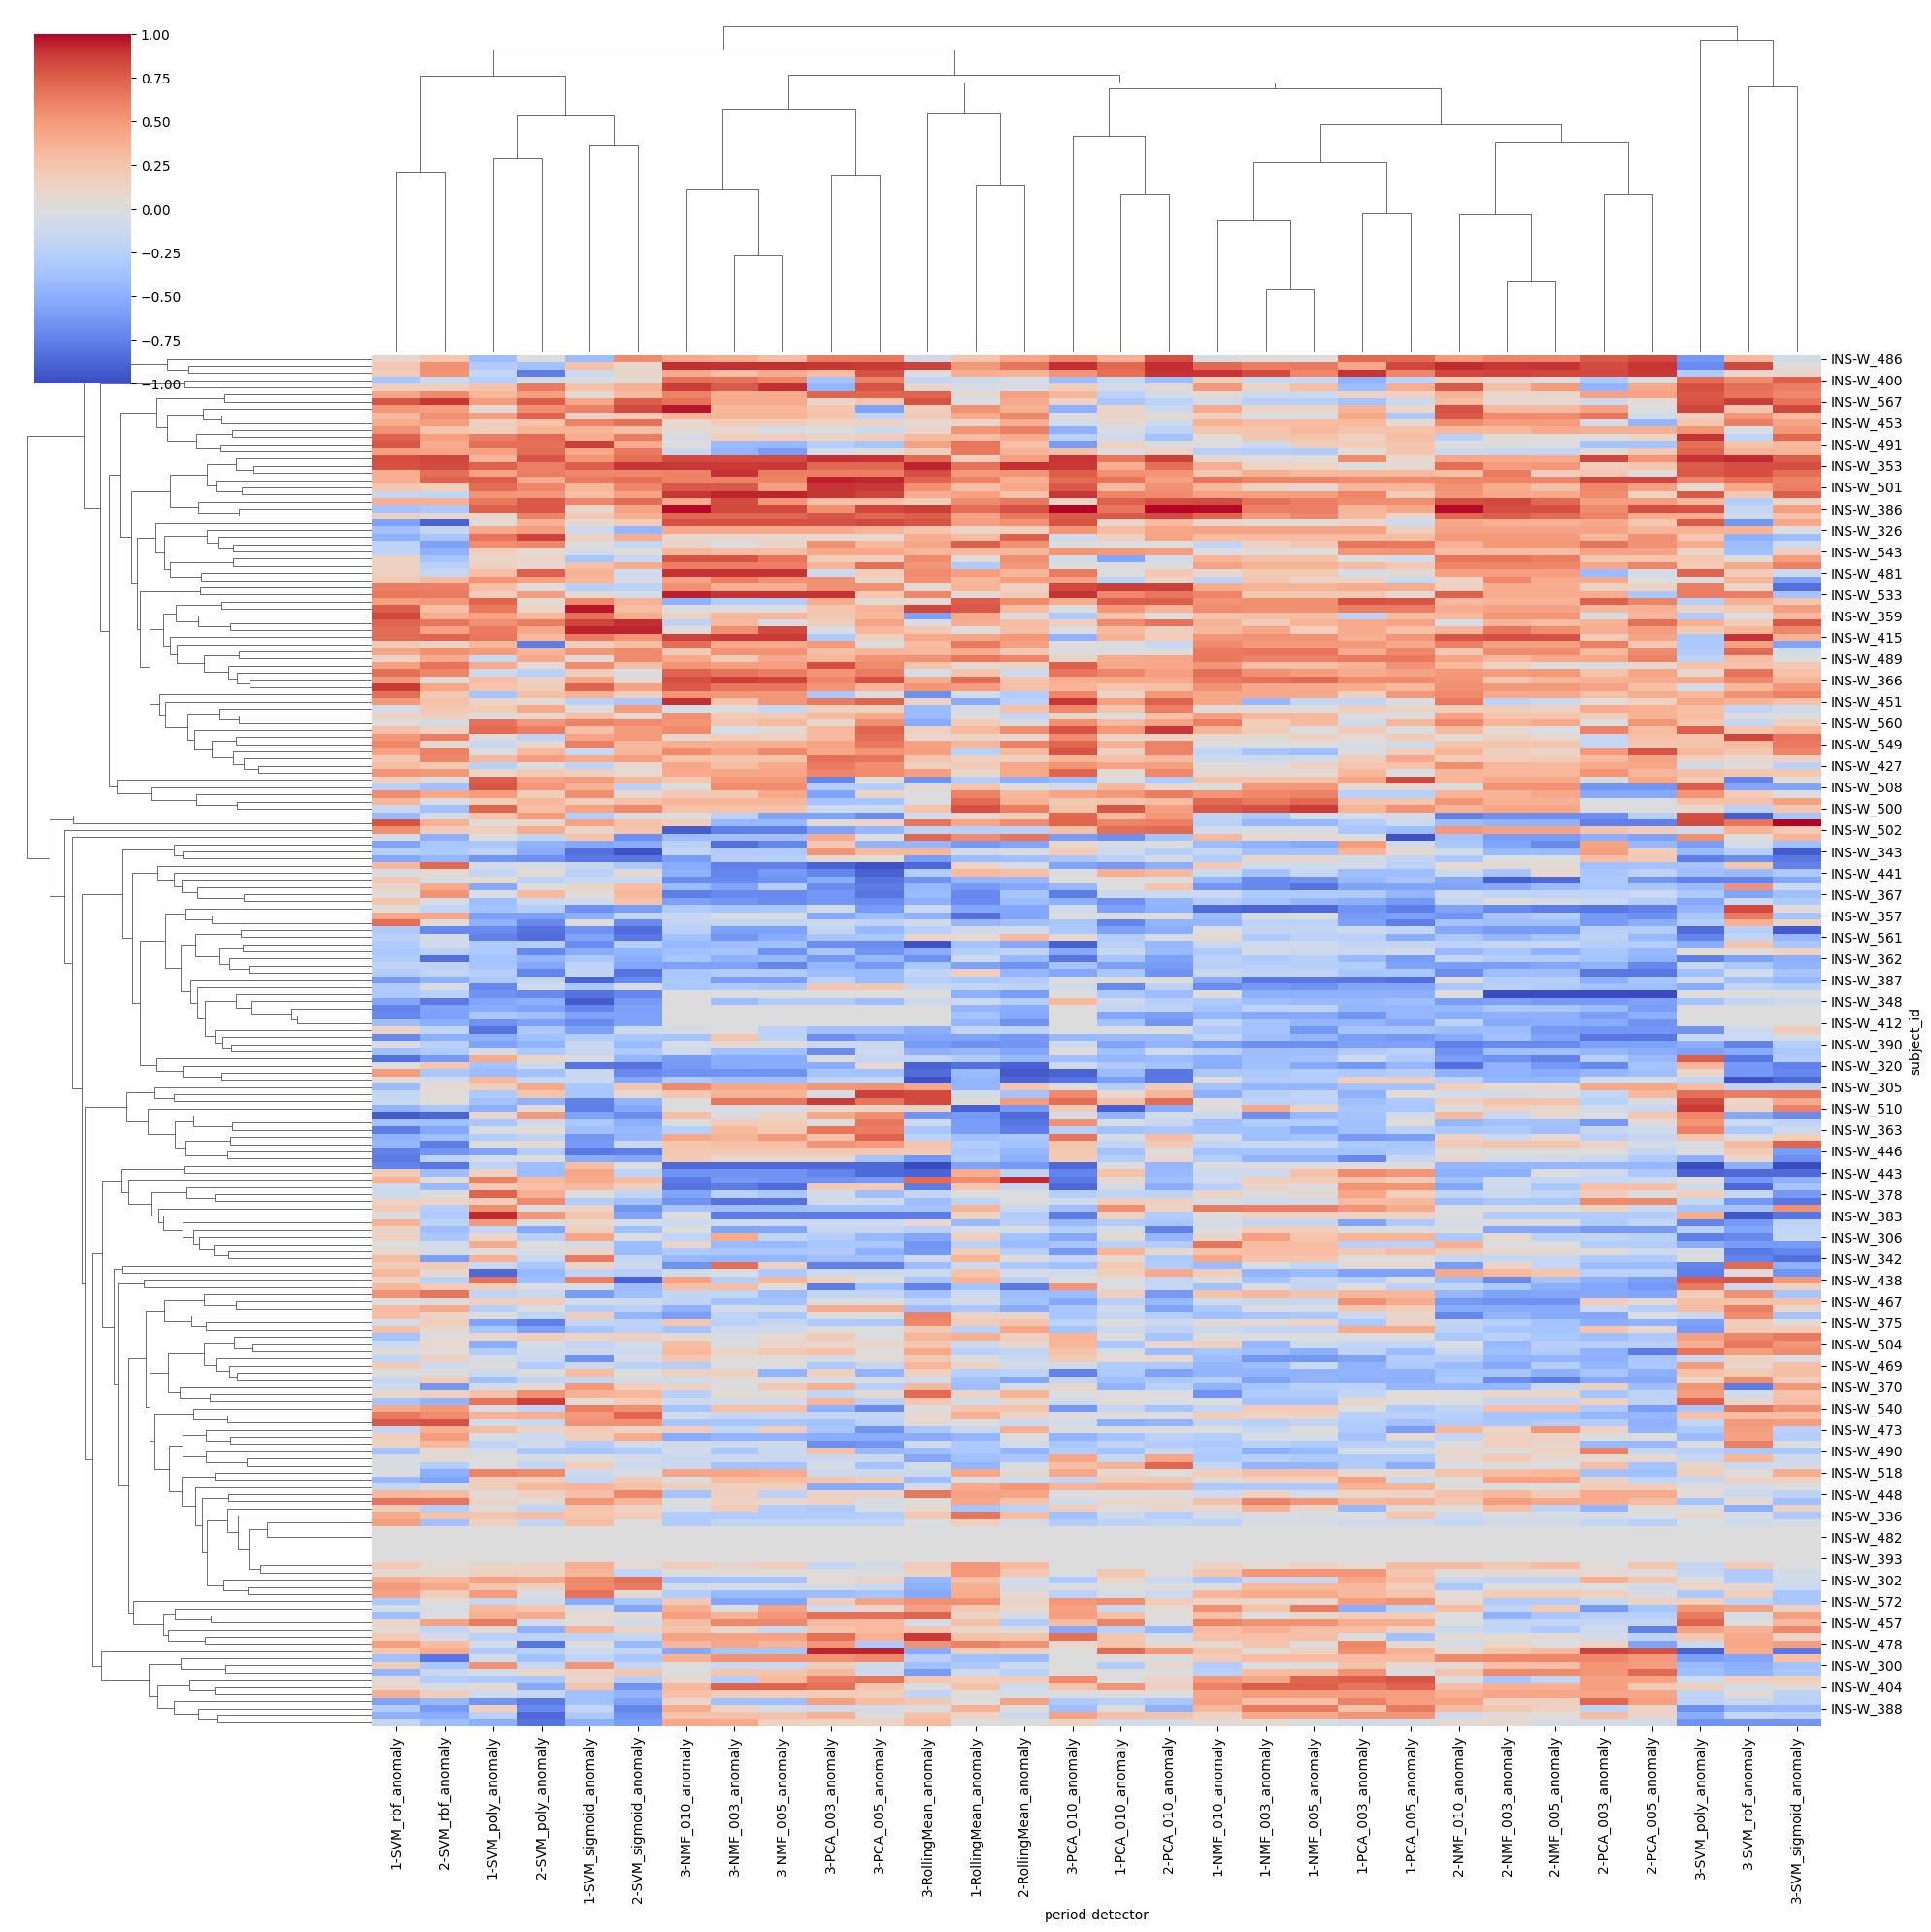

In [13]:
vals = corr.pivot_table(
    index='subject_id',
    columns=['period', 'detector'],
    values='rho',
)

anot = corr.pivot_table(
    index='subject_id',
    columns=['period', 'detector'],
    values='p',
)

anot = (anot < 0.05)

sns.clustermap(
    vals,
    #annot=anot,
    cmap='coolwarm',
    #col_cluster=False,
    vmin=-1,
    vmax=1,
    figsize=(20,20)
)

In [14]:
corr.period.nunique()

3

In [33]:
model_order = [
    'RollingMean',
    'PCA_003',
    'PCA_005',
    'PCA_010',
    'NMF_003',
    'NMF_005',
    'NMF_010',
    'SVM_rbf',
    'SVM_sigmoid',
    'SVM_poly',
]


In [103]:
l = .8
p_int = {
    m: Color(c)
    for m, c in palette['model'].items()

}
for m, c in p_int.items():
    c.set_luminance(l)

p_t= {
    m: c.get_hex_l()
    for m, c in p_int.items()
}

p_t

{'Linear Regression': '#c5cbd3',
 'Random Forest Regression': '#b0c0e8',
 'Gradient Boosting Regression': '#b7cde1',
 'Mixed Effects Random Forest': '#dcb7e1',
 'Baseline': '#cccccc',
 'Logistic Regression': '#c5cbd3',
 'Random Forest Classifier': '#b0c0e8',
 'Gradient Boosting Classifier': '#b7cde1',
 'PCA': '#b6e2db',
 'PCA_003': '#b6e2db',
 'PCA_005': '#b6e2db',
 'PCA_010': '#b6e2db',
 'NMF': '#a6f2bf',
 'NMF_003': '#a6f2bf',
 'NMF_005': '#a6f2bf',
 'NMF_010': '#a6f2bf',
 'SVM': '#f0a8b6',
 'SVM_rbf': '#f0a8b6',
 'SVM_poly': '#e0b8c0',
 'SVM_sigmoid': '#ebadcc',
 'IsolationForest': '#ebe0ad',
 'RollingMean': '#a6d9f2'}

Text(0.5, 0, 'R-squared')

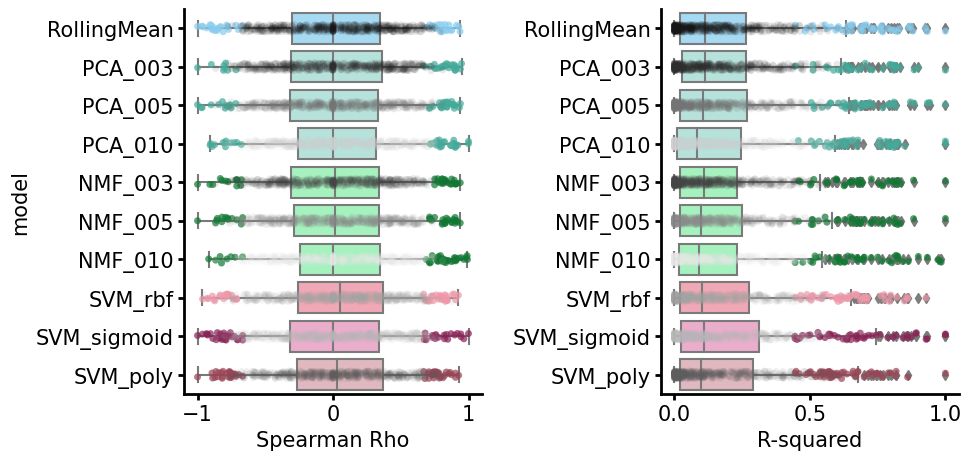

In [104]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
plt.subplots_adjust(wspace=.6)
ns = corr[corr.p > 0.05]
sig = corr[corr.p < 0.05]
corr['model'] = corr['detector'].str.split('_anomaly').str[0]
p_transparent = {
    m: Color(c).get_rgb()
    for m, c in palette['model'].items()
}
for i, metric in enumerate(['rho', 'r2']):
    ax = axes[i]
    sns.stripplot(
        y='model',
        x=metric,
        data=sig,
        hue='model',
        palette=palette['model'],
        order=model_order,
        alpha=0.7,
        ax=ax
    )
    sns.stripplot(
        y='model',
        x=metric,
        data=ns,
        hue='model',
        palette='gray',
        order=model_order,
        alpha=0.1,
        ax=ax
    )
    sns.boxplot(
        y='model',
        x=metric,
        data=corr,
        hue='model',
        palette=p_t,
        #palette=palette['model'],
        #color='white',
        saturation=1,
        order=model_order,
        dodge=False,
        ax=ax
    )
    fa.despine_thicken_axes(ax, fontsize=15)
    ax.legend().remove()
    ax.set_xlabel('Spearman Rho')
ax.set_ylabel('')
ax.set_xlabel('R-squared')

In [59]:
sig_corr = corr[corr.p < 0.05]
sig_corr[sig_corr.period == 1].sort_values(by='rho').round(3)

,detector,rho,p,n,subject_id,period,r2,model
5224,PCA_005_anomaly,-0.966,0.000,7,INS-W_545,1,0.933,PCA_005
4746,SVM_rbf_anomaly,-0.928,0.000,9,INS-W_522,1,0.861,SVM_rbf
1117,SVM_sigmoid_anomaly,-0.926,0.000,9,INS-W_348,1,0.857,SVM_sigmoid
4538,PCA_010_anomaly,-0.907,0.002,8,INS-W_510,1,0.822,PCA_010
4530,RollingMean_anomaly,-0.907,0.002,8,INS-W_510,1,0.822,RollingMean
...,...,...,...,...,...,...,...,...
4171,PCA_003_anomaly,0.904,0.002,8,INS-W_492,1,0.816,PCA_003
1863,SVM_poly_anomaly,0.928,0.008,6,INS-W_383,1,0.861,SVM_poly
5107,SVM_sigmoid_anomaly,0.944,0.000,9,INS-W_541,1,0.891,SVM_sigmoid
1897,SVM_sigmoid_anomaly,0.966,0.000,9,INS-W_385,1,0.933,SVM_sigmoid


/var/folders/yl/t10bslz11cgdwwfk10mvyr1h0000gn/T/ipykernel_6416/2075002908.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_data[AD_col] = subject_data[AD_col].fillna(False)
/Users/akre96/Code/dgc/mhealth_anomaly_detection/notebooks/../mhealth_anomaly_detection/plots.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f] = pd.to_numeric(data[f], errors='coerce')
/Users/akre96/Code/dgc/mhealth_anomaly_detection/notebooks/../mhealth_anomaly_detection/plots.py:48: SettingWithCopyWarning: 
A v

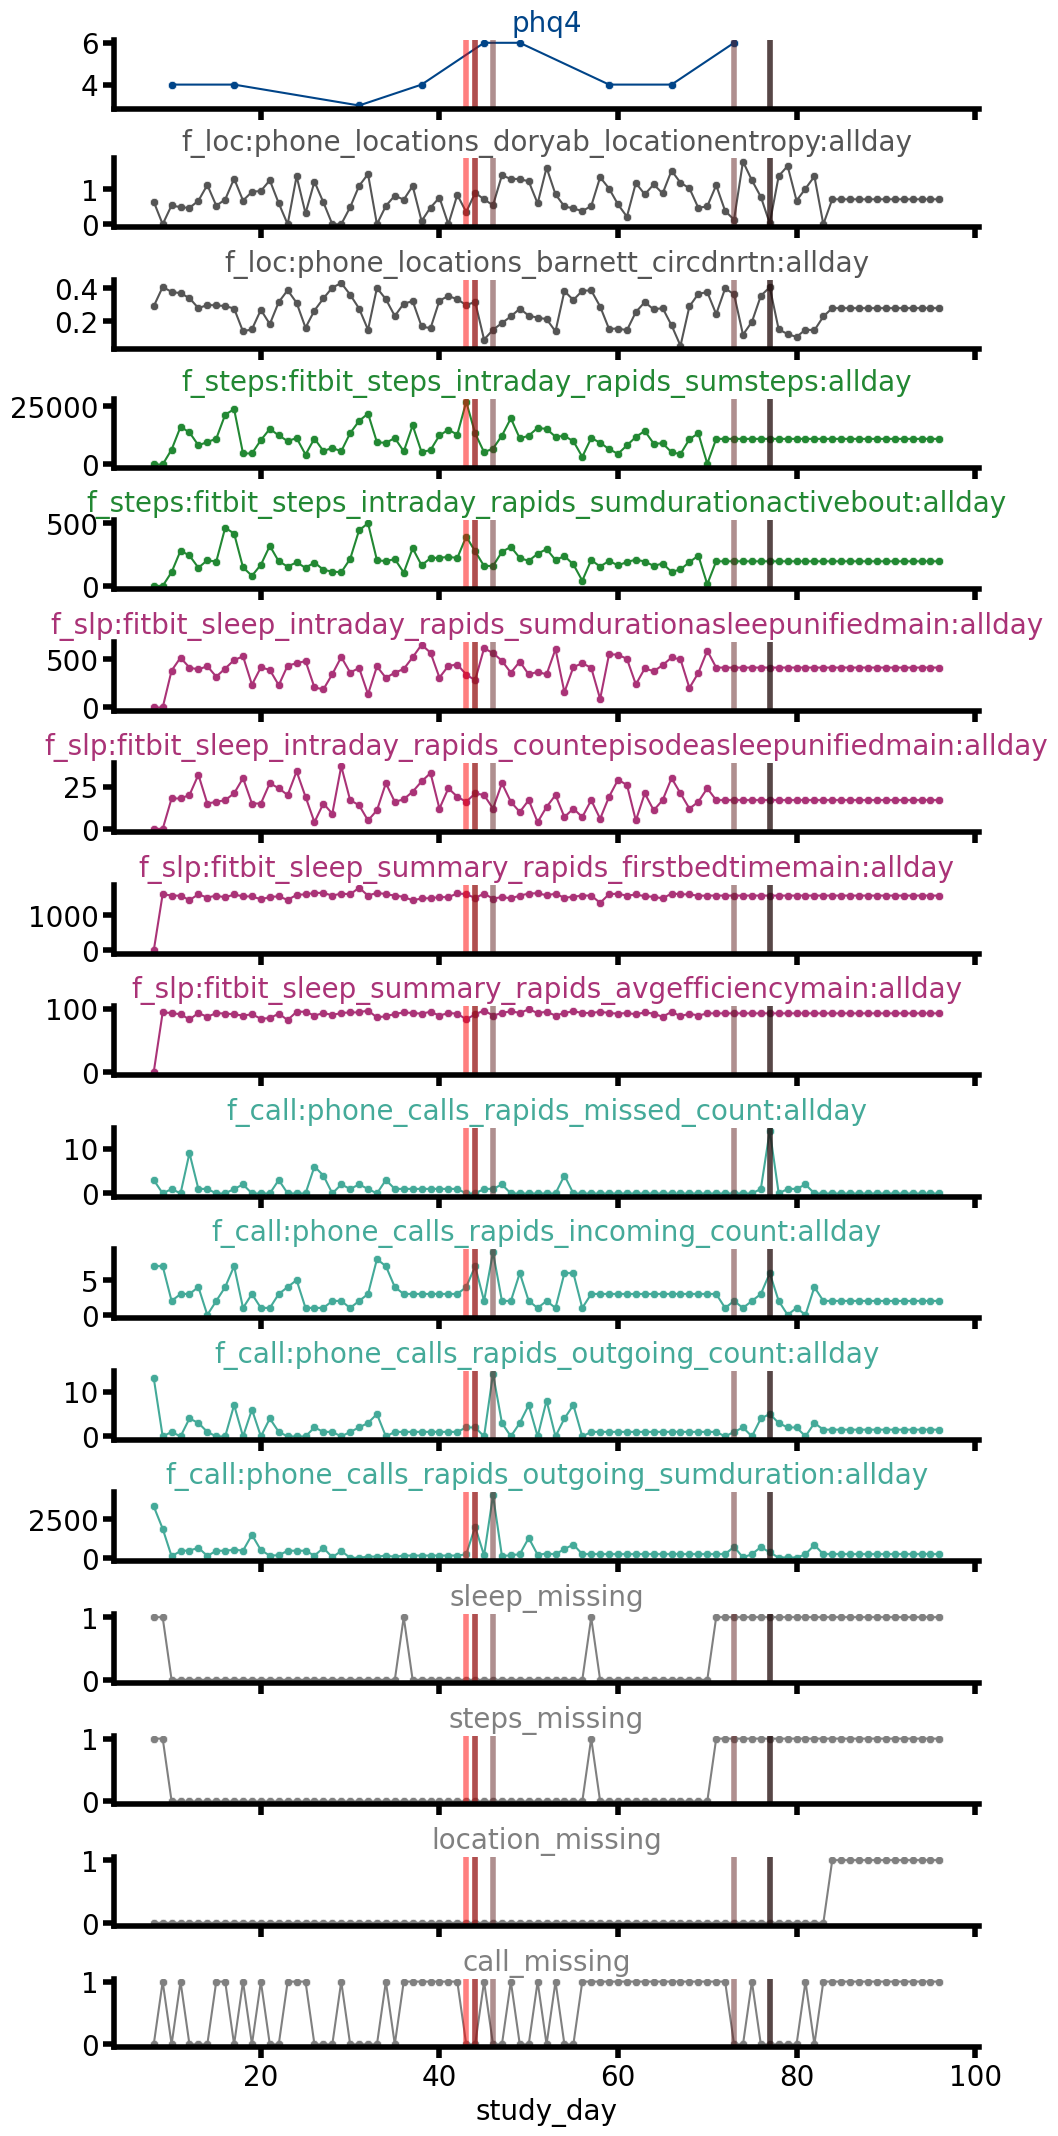

In [23]:
sid = 'INS-W_492'
AD_col = 'PCA_003_anomaly'
window_size = 7
features = [
    'f_loc:phone_locations_doryab_locationentropy:allday',
    'f_loc:phone_locations_barnett_circdnrtn:allday',
    'f_steps:fitbit_steps_intraday_rapids_sumsteps:allday',
    'f_steps:fitbit_steps_intraday_rapids_sumdurationactivebout:allday',
    'f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:allday',
    'f_slp:fitbit_sleep_intraday_rapids_countepisodeasleepunifiedmain:allday',
    'f_slp:fitbit_sleep_summary_rapids_firstbedtimemain:allday',
    'f_slp:fitbit_sleep_summary_rapids_avgefficiencymain:allday',
    'f_call:phone_calls_rapids_missed_count:allday',
    'f_call:phone_calls_rapids_incoming_count:allday',
    'f_call:phone_calls_rapids_outgoing_count:allday',
    'f_call:phone_calls_rapids_outgoing_sumduration:allday',
    'sleep_missing',
    'steps_missing',
    'location_missing',
    'call_missing',
]
palette = lr.get_colors('../lib/colors.json')
subject_data = exp06_ad[
    (exp06_ad.subject_id == sid) &
    (exp06_ad.window_size == window_size)
]
subject_data[AD_col] = subject_data[AD_col].fillna(False)
_, axes = plots.lineplot_features(
    subject_data,
    plot_features=['phq4'] + features,
    scatter=True,
    palette=palette
)
pal = list(Color('red').range_to(Color('black'), 3))
for i, (ws, w_df) in enumerate(exp06_ad[exp06_ad.subject_id == sid].groupby('window_size')):
    ads = w_df[w_df[AD_col] == 1].study_day
    
    for ax in axes.flatten():
        ylims = ax.get_ylim()
        ax.vlines(ads, *ylims, color=pal[i].hex_l, lw=4, alpha=.5)
        ax.set_ylim(*ylims)
